### Imports

In [23]:
import numpy as np
import scipy as sp
from itertools import combinations
import matplotlib.pyplot as plt

### Functions

In [24]:
def basis_set_generator(tot_sites, N_e_up, N_e_down):
    spin_up_basis = []
    spin_down_basis = []

    for comb_up in combinations(range(tot_sites), N_e_up):
        state = [0] * tot_sites
        for idx in comb_up:
            state[idx] = 1
        spin_up_basis.append(state)

    for comb_down in combinations(range(tot_sites), N_e_down):
        state = [0] * tot_sites
        for idx in comb_down:
            state[idx] = 1
        spin_down_basis.append(state)

    basis = []

    for up_state in spin_up_basis:
        for down_state in spin_down_basis:
            basis.append(up_state + down_state)
    
    return np.array(basis)



def creation_operator(state, site):
    
    res_state = state.copy()
    
    if state[site] == 1:
        return 0, None
    
    sign = 1
    for i in range(site):
        if state[i] == 1:
            sign = sign * -1
    
    res_state[site] = 1
    return sign, res_state



def annihilation_operator(state, site):
    
    res_state = state.copy()
    
    if state[site] == 0:
        return 0, None
    
    sign = 1
    for i in range(site):
        if state[i] == 1:
            sign = sign * -1
    
    res_state[site] = 0
    return sign, res_state



def hopping_operator(state, create_site, destroy_site):

    if (state[create_site] == 1) and (state[destroy_site] == 0):
        return 0, None

    sign_destroy, res_state = annihilation_operator(state, destroy_site)
    
    sign_create, res_state = creation_operator(res_state, create_site)

    return (sign_create * sign_destroy), res_state



def state_idx_mapping(basis_set):
    return {tuple(state) : i for i, state in enumerate(basis_set)}



def hamiltonian_matrix_generator(basis_set, tot_sites, J_11, J_1, J_33, J_3, U):
    dim = len(basis_set)
    hamiltonian = np.zeros((dim, dim), dtype=np.float64)
    state_idx_dict = state_idx_mapping(basis_set)

    for i, state in enumerate(basis_set):
        for j in range(tot_sites):
            for k in [0, tot_sites]:
                l = j + k
                # print(l)

                if state[l] == 0:
                    continue

                if (l + 1) < (tot_sites + k): # J_11 & J_1 terms
                    if state[l + 1] == 0:
                        destroy_site = l
                        create_site = l + 1
                        # print(initial_position, target_position)
                        sign, res_state = hopping_operator(state, create_site, destroy_site)
                        # print(sign, res_state)

                        # print(f"{state} ---- {destroy_site} ---- {create_site} ---- {sign} ---- {res_state}")

                        if sign == 0:
                            continue

                        res_state_idx = state_idx_dict[tuple(res_state)]
                        # print(res_state_idx)

                        if l % 2 == 0:
                            hamiltonian[res_state_idx, i] += J_11 * sign
                        else:
                            hamiltonian[res_state_idx, i] += J_1 * sign
                
                if l - 1 >= k: # Hermitian conjugate of J_11 & J_1 terms
                    if state[l - 1] == 0:
                        destroy_site = l
                        create_site = l - 1
                        # print(initial_position, target_position)
                        sign, res_state = hopping_operator(state, create_site, destroy_site)
                        # print(sign, res_state)

                        # print(f"{state} ---- {destroy_site} ---- {create_site} ---- {sign} ---- {res_state}")

                        if sign == 0:
                            continue

                        res_state_idx = state_idx_dict[tuple(res_state)]
                        # print(res_state_idx)

                        if l % 2 == 0:
                            hamiltonian[res_state_idx, i] += J_1 * sign
                        else:
                            hamiltonian[res_state_idx, i] += J_11 * sign
                
                if (l + 3) < (tot_sites + k): # J_33 & J_3 terms
                    if state[l + 3] == 0:
                        destroy_site = l
                        create_site = l + 3
                        # print(initial_position, target_position)
                        sign, res_state = hopping_operator(state, create_site, destroy_site)
                        # print(sign, res_state)

                        # print(f"{state} ---- {destroy_site} ---- {create_site} ---- {sign} ---- {res_state}")

                        if sign == 0:
                            continue

                        res_state_idx = state_idx_dict[tuple(res_state)]
                        # print(res_state_idx)

                        if l % 2 == 0:
                            hamiltonian[res_state_idx, i] += J_33 * sign
                        else:
                            hamiltonian[res_state_idx, i] += J_3 * sign
                
                if (l - 3) >= k: # Hermitian conjugate of J_33 & J_3 terms
                    if state[l - 3] == 0:
                        destroy_site = l
                        create_site = l - 3
                        # print(initial_position, target_position)
                        sign, res_state = hopping_operator(state, create_site, destroy_site)
                        # print(sign, res_state)

                        # print(f"{state} ---- {destroy_site} ---- {create_site} ---- {sign} ---- {res_state}")

                        if sign == 0:
                            continue

                        res_state_idx = state_idx_dict[tuple(res_state)]
                        # print(res_state_idx)

                        if l % 2 == 0:
                            hamiltonian[res_state_idx, i] += J_3 * sign
                        else:
                            hamiltonian[res_state_idx, i] += J_33 * sign
    
    for i, state in enumerate(basis_set):
        for j in range(tot_sites):
            if state[j] == state[j + tot_sites] and state[j] == 1:
                hamiltonian[i, i] += U
    
    return hamiltonian



def normalize(state):
    return state / (np.linalg.norm(state))



def state_to_position_space_spin_combined(state, basis_set, tot_sites, dim):
    pos_sp_state = np.zeros((tot_sites))

    for i in range(dim):
        pos_sp_state += basis_set[i][0 : tot_sites] * state[i]
        pos_sp_state += basis_set[i][tot_sites : 2 * tot_sites] * state[i]
    
    return normalize(pos_sp_state)



def state_to_position_space(state, basis_set, tot_sites, dim):
    pos_sp_state = np.zeros((2 * tot_sites))

    for i in range(dim):
        pos_sp_state += basis_set[i] * state[i]
    
    return normalize(pos_sp_state)



def S_z_j(state, j, tot_sites):
    return ((state[j] - state[tot_sites + j]) * 0.5)



def C_jk(e_vec_pos_sp, j, k, dim, tot_sites):
    res = 0
    for state in e_vec_pos_sp:
        res += S_z_j(state, j, tot_sites) * S_z_j(state, k, tot_sites)
    
    return res / dim


### Simulation

#### System Defination

In [25]:
tot_sites = 8
N_e_up = 4
N_e_down = N_e_up
J_11 = 0.1
J_1 = 0.1
J_33 = 0.1
J_3 = 0.1
U = 10

#### Basis and Hamiltonian Creation

In [26]:
basis_set = basis_set_generator(tot_sites, N_e_up, N_e_down)

hamiltonian = hamiltonian_matrix_generator(basis_set, tot_sites, J_11, J_1, J_33, J_3, U)

#### Diagonalization

In [27]:
e_val_arr, e_vec_arr = np.linalg.eigh(hamiltonian)
e_vec_arr_transpose = e_vec_arr.transpose()

#### State to Position Space

In [28]:
dim = len(basis_set)
e_vec_pos_sp = np.zeros((dim, 2 * tot_sites))

for i, state in enumerate(e_vec_arr_transpose):
    e_vec_pos_sp[i] = state_to_position_space(state, basis_set, tot_sites, dim)

#### Calculating Spin-Spin Correlation

In [29]:
spin_spin_correlation = np.zeros((tot_sites, tot_sites))

for j in range(tot_sites):
    for k in range(tot_sites):
        spin_spin_correlation[j, k] = C_jk(e_vec_pos_sp, j, k, dim, tot_sites)

### Archives & Tests

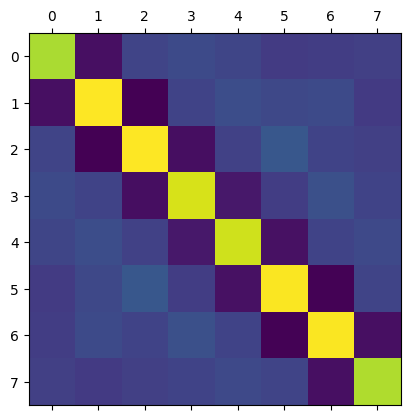

In [30]:
plt.matshow(spin_spin_correlation)
plt.show()

In [31]:
print(np.shape(e_vec_pos_sp))

(4900, 16)


In [32]:
E = e_vec_arr_transpose @ hamiltonian @ e_vec_arr
dim = len(basis_set)

for i in range(dim):
    print(np.round(e_val_arr[i], decimals=5), end='|')
print()
for i in range(dim):
    print(np.round(E[i, i], decimals=5), end='|')

print()

for i in range(dim):
    if np.round(e_val_arr[i], decimals=5) != np.round(E[i, i], decimals=5):
        print(False)
        break

-0.03103|-0.02823|-0.02414|-0.02327|-0.02228|-0.02225|-0.02192|-0.02172|-0.02157|-0.02057|-0.02048|-0.02036|-0.01897|-0.01856|-0.01814|-0.01791|-0.01739|-0.01711|-0.01693|-0.01688|-0.01685|-0.01628|-0.01618|-0.01612|-0.016|-0.016|-0.01566|-0.01531|-0.01516|-0.01512|-0.01485|-0.01476|-0.01388|-0.01382|-0.01316|-0.01305|-0.01285|-0.01279|-0.01259|-0.01241|-0.012|-0.01147|-0.01129|-0.0112|-0.01096|-0.01096|-0.01077|-0.01066|-0.01066|-0.00999|-0.00957|-0.0094|-0.00884|-0.00872|-0.00872|-0.00846|-0.0082|-0.008|-0.008|-0.008|-0.00772|-0.00711|-0.00694|-0.00681|-0.00608|-0.00543|-0.00479|-0.004|-0.00241|0.0|9.46736|9.47878|9.48839|9.495|9.50307|9.51441|9.51721|9.51823|9.53212|9.53269|9.53369|9.53372|9.53837|9.54062|9.5411|9.54181|9.54285|9.54309|9.54416|9.54468|9.54714|9.54946|9.55053|9.55121|9.55173|9.55625|9.55743|9.55794|9.55864|9.55893|9.56333|9.56473|9.56624|9.56625|9.56648|9.57312|9.57327|9.57444|9.57575|9.58127|9.58243|9.58632|9.58908|9.58926|9.58984|9.59103|9.59445|9.59857|9.59897|9.5

In [33]:
# print(len(e_val_arr))
# print(e_val_arr)

# count = 0
# state_idx = 0
# for i, e in enumerate(np.abs(e_val_arr)):
#     if e < 10**(-10):
#         # state_idx = i
#         print(i, e)
#         count += 1
# # print(count)

# state_ps = state_to_position_space(e_vec_arr[state_idx], basis_set, tot_sites, len(basis_set))

for i, e in enumerate(e_val_arr):
    print(f'{i}---------- {e}')

0---------- -0.03103031627816523
1---------- -0.028228142976270576
2---------- -0.024137709194268494
3---------- -0.023268849656898124
4---------- -0.022282147903453838
5---------- -0.022248385411662276
6---------- -0.02192012283995624
7---------- -0.021722725521810884
8---------- -0.02157182099115086
9---------- -0.02057166383243162
10---------- -0.020475483010304607
11---------- -0.020356559273927488
12---------- -0.018973338913147276
13---------- -0.0185591940106533
14---------- -0.018135557389408308
15---------- -0.017909287930325778
16---------- -0.017390651078316454
17---------- -0.017110765356235586
18---------- -0.0169320901529797
19---------- -0.016881579780526568
20---------- -0.016851765791787602
21---------- -0.016283900997319137
22---------- -0.016184539610405453
23---------- -0.01611899933366675
24---------- -0.016000352667302976
25---------- -0.015999093880102056
26---------- -0.01566089253632034
27---------- -0.015311515916614421
28---------- -0.015156058610616759
29---